In [3]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(data.table)

In [7]:
#Load in the data and format it
setwd("../data")
ccle.chronos = fread("22q1_crispr_gene_effect.csv", sep = ",", header = TRUE, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

#Load in the 22Q2 chronos scores
setwd("../data")
ccle.chronos.new = fread("22q2_crispr_gene_effect.csv", sep = ",", header = TRUE, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [8]:
#First, calculate the overlapping set of samples between the two datasets
overlapping.samples = intersect(ccle.chronos$sample, ccle.chronos.new$sample)

#Calculate the mean chronos score for all genes for 22q1
chronos.score.22q1 = ccle.chronos %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample) %>%
apply(2, mean) %>%
data.frame() %>%
rename("mean_22q1_score" = 1) %>%
mutate("gene" = colnames(ccle.chronos)[2:ncol(ccle.chronos)])

#Now do the same for 22q2
chronos.score.22q2 = ccle.chronos.new %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample) %>%
apply(2, mean) %>%
data.frame() %>%
rename("mean_22q2_score" = 1) %>%
mutate("gene" = colnames(ccle.chronos)[2:ncol(ccle.chronos)])


#Now merge the two datasets together and add a bit of extra information
merged.mean.chronos.scores = inner_join(chronos.score.22q1, chronos.score.22q2, by = "gene") %>%
drop_na() %>%
mutate("differential" = mean_22q2_score - mean_22q1_score) 

In [9]:
#Filter the two datasets so that they have overlapping samples and genes (again)
chronos.22q1.filtered = ccle.chronos %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

chronos.22q2.filtered = ccle.chronos.new %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

In [10]:
#Compute the p-values between the two data frames 
pvals = Map(wilcox.test, chronos.22q1.filtered, chronos.22q2.filtered)

extracted.pvals = pvals %>% lapply(function(x){
    val = x$p.value
    return(val)
}) %>%
unlist() %>%
as.numeric()

In [11]:
#Create a data frame with the p-values and the mean differences
difference.between.22q1.22q2.df = cbind(colnames(chronos.22q1.filtered), extracted.pvals, merged.mean.chronos.scores$differential) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "differential" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(differential = as.numeric(differential)) %>%
mutate("fdr" = p.adjust(pval, method = "BH", n = length(pval)))

Warning message in cbind(colnames(chronos.22q1.filtered), extracted.pvals, merged.mean.chronos.scores$differential):
“number of rows of result is not a multiple of vector length (arg 3)”


In [12]:
#Calculate the total number of significant differences
difference.between.22q1.22q2.df %>% 
filter(fdr < 0.05) %>%
pull(gene) %>%
unique() %>%
length()

[1] 2223

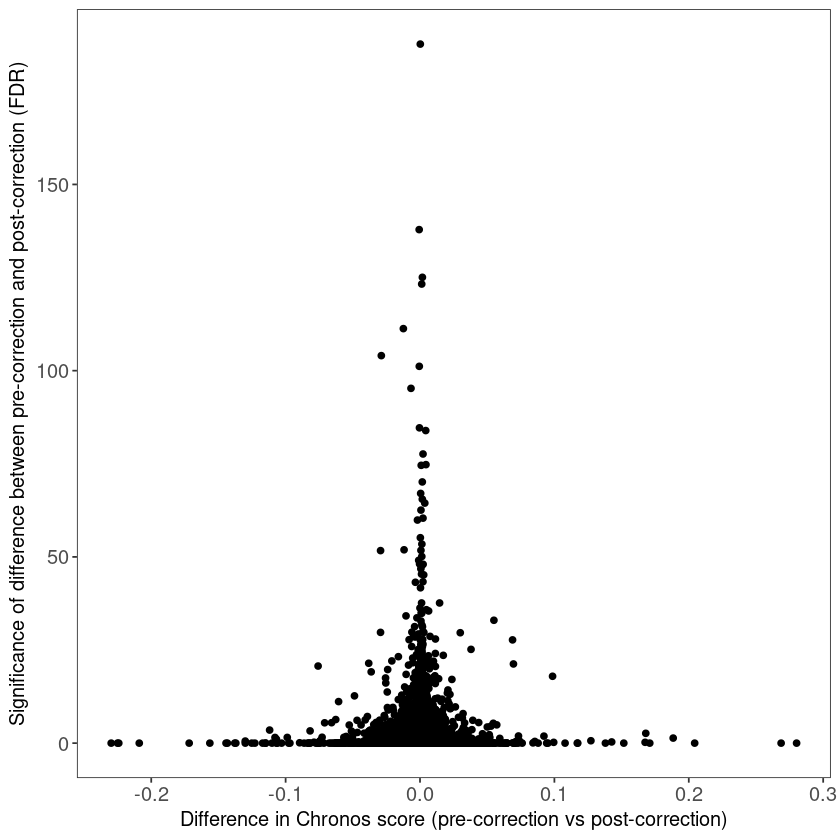

In [13]:
#Plot the volcano plot
difference.between.22q1.22q2.df %>%
ggplot(aes(x = differential, y = -log10(fdr))) +
geom_point() +
theme_bw() +

scale_color_manual(values = c("black", "blue")) +
scale_fill_manual(values = c("black", "blue")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Significance of difference between pre-correction and post-correction (FDR)") +
xlab("Difference in Chronos score (pre-correction vs post-correction)")

#Export it to the google bucket
setwd('../output')
ggsave("supplemental_figure_11.pdf", width = 5, height = 5)

In [15]:
#Export the df
setwd("../output")
write.table(difference.between.22q1.22q2.df, "supplemental_figure_11_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)